# Figure 8

In [1]:
using CacheVariables, LaTeXStrings, LinearAlgebra, Plots, ProgressMeter, Random, Statistics, StructArrays
pyplot()
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2667 v2 @ 3.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, ivybridge)


## Utility functions

In [2]:
function pairwise(σ,σt,α)
    khp1 = findfirst(kp1 -> σ[kp1] <= quantile(getindex.(σt,kp1),α),1:length(σ))
    return !isnothing(khp1) ? khp1-1 : length(σ)
end

pairwise (generic function with 1 method)

In [3]:
function upperedge(σ,σt,α)
    σt1 = quantile(getindex.(σt,1),α)
    khp1 = findfirst(kp1 -> σ[kp1] <= σt1,1:length(σ))
    return !isnothing(khp1) ? khp1-1 : length(σ)
end

upperedge (generic function with 1 method)

In [4]:
_nonneg(x) = max(x,zero(x))
_svdvals(X) = sqrt.(_nonneg.(eigvals!(size(X,1) < size(X,2) ? X*X' : X'X,sortby=-)))

_svdvals (generic function with 1 method)

## Example scree plot

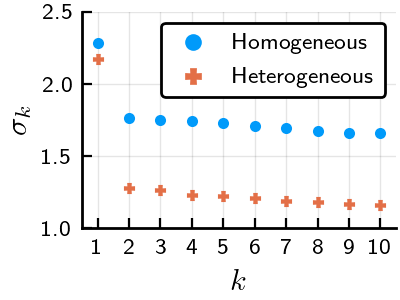

In [5]:
θ, n, p = 2, 500, 300

plot(xlabel=L"k",ylabel=L"\sigma_k",xlims=(0.5,10.5),ylims=(1,2.5),xticks=1:10,yticks=1:0.5:2.5)
plot!(legend=:topright,size=(200,150),dpi=200)

Random.seed!(0)
u, v = normalize(randn(n)), normalize(randn(p))
E = randn(n,p)/sqrt(n)
scatter!(svdvals(θ*u*v'+E),markerstrokewidth=0,markerstrokealpha=0,label="Homogeneous")

Random.seed!(0)
u, v = normalize(randn(n)), normalize(randn(p))
E = [sqrt(0.4)*randn(n÷10*9,p); randn(n÷10,p)]/sqrt(n)
scatter!(svdvals(θ*u*v'+E),markerstrokewidth=0,markerstrokealpha=0,markershape=:cross,label="Heterogeneous")

## Simulation: Average rank estimate $\hat{k}$

In [6]:
Random.seed!(0)

n, p = 500, 300
θrange = 0.02:0.02:6
runs = 1000

kh_avg = @cache "Figure 08/rank,est,mean.bson" @showprogress map(θrange) do θ
    kh = map(1:runs) do _
        # Generate data
        u, v = normalize(randn(n)), normalize(randn(p))
        E = [sqrt(0.4)*randn(n÷10*9,p); randn(n÷10,p)]/sqrt(n)
        
        X = θ*u*v' + E
        
        # Parallel analysis via permutation and signflips
        σ = _svdvals(X)
        
        σp = [_svdvals(mapslices(shuffle,X,dims=1)) for _ in 1:10]
        permpair=pairwise(σ,σp,0.95)
        permedge=upperedge(σ,σp,0.95)
        
        σf = [_svdvals(X .* rand([1,-1],size(X))) for _ in 1:10]
        flippair=pairwise(σ,σf,0.95)
        flipedge=upperedge(σ,σf,0.95)
        
        return (permpair=permpair,permedge=permedge,flippair=flippair,flipedge=flipedge)
    end
    return map(mean,fieldarrays(StructArray(kh)))
end
#;

┌ Info: Loading from Figure 08/rank,est,mean.bson
└ @ Main /home/stat/dahong67/.julia/packages/CacheVariables/fTHJM/src/CacheVariables.jl:31


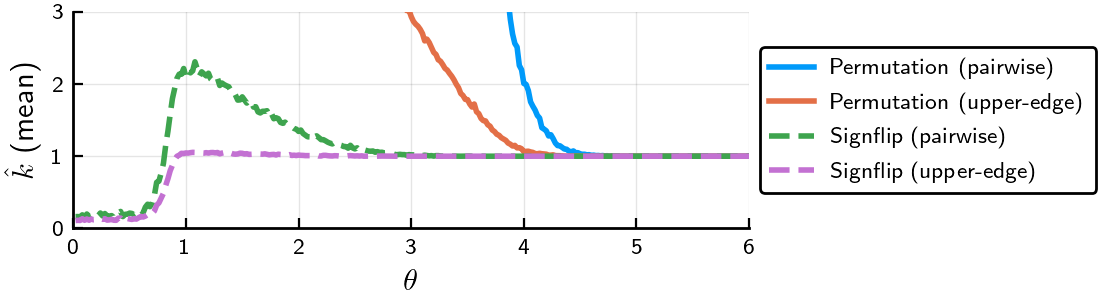

In [7]:
plot(xlabel=L"\theta",ylabel=L"$\hat{k}$ (mean)",xlims=(0,6),ylims=(0,3))
plot!(legend=:outerright,size=(550,150),dpi=200)
plot!(θrange,getfield.(kh_avg,:permpair),linewidth=2,label="Permutation (pairwise)")
plot!(θrange,getfield.(kh_avg,:permedge),linewidth=2,label="Permutation (upper-edge)")
plot!(θrange,getfield.(kh_avg,:flippair),linewidth=2,label="Signflip (pairwise)",linestyle=:dash)
plot!(θrange,getfield.(kh_avg,:flipedge),linewidth=2,label="Signflip (upper-edge)",linestyle=:dash)

## Distribution of leading noise singular value

In [8]:
Random.seed!(0)

Enorms = @cache "Figure 08/noise,dist.bson" @showprogress map(1:20000) do _
    E = [sqrt(0.4)*randn(n÷10*9,p); randn(n÷10,p)]/sqrt(n)
    Ep = mapslices(shuffle,E,dims=1)
    Ef = E .* rand([1,-1],size(E))
    (orig=opnorm(E), perm=opnorm(Ep), flip=opnorm(Ef))
end
#;

┌ Info: Loading from Figure 08/noise,dist.bson
└ @ Main /home/stat/dahong67/.julia/packages/CacheVariables/fTHJM/src/CacheVariables.jl:31


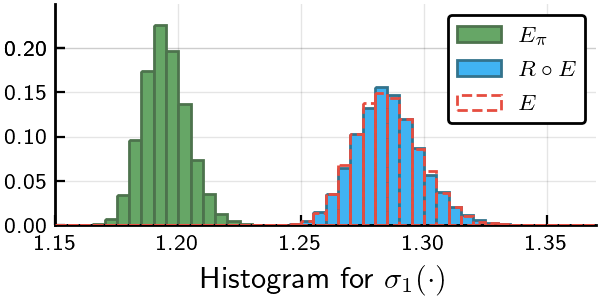

In [9]:
edges = 1.15:0.005:1.37
plot(xlabel=L"Histogram for $\sigma_1(\cdot)$",xlims=(1.15,1.37),ylims=(0,0.25),xticks=1.15:0.05:1.35)
plot!(legend=:topright,size=(300,150),dpi=200)
histogram!(getfield.(Enorms,:perm),bins=edges,normalize=:probability,label=L"E_\pi",
    color=RGB(0.40,0.65,0.40),linecolor=RGB(0.30,0.45,0.30))
histogram!(getfield.(Enorms,:flip),bins=edges,normalize=:probability,label=L"R \circ E",
    color=RGB(0.25,0.70,0.95),linecolor=RGB(0.20,0.45,0.55))
histogram!(getfield.(Enorms,:orig),bins=edges,normalize=:probability,label=L"E",
    fill=nothing,linecolor=RGB(0.90,0.30,0.25),linestyle=:dash)